In [4]:
import os
import pandas as pd
from transformers import AutoModel, AutoTokenizer
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import AdamW
import torch
from torch import nn
from torch.nn.utils.rnn import pad_sequence
from transformers import get_linear_schedule_with_warmup
import gc
import numpy as np
import pandas as pd
import time
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.functional as F


In [5]:
data_path = './data/VulnTraceData/finetune_dataset/'
model_name = 'DeepSoftwareAnalytics/CoCoSoDa'

project_list = ['binutils', 'ffmpeg', 'libarchive', 'libxml2', 'systemd', 'tcpdump']
# model_name_list = ['cocosoda', 'unixcoder-base', 'graphcodebert-base', 'codebert-base', 'roberta-base', 'roberta-code']
model_name_list = ['cocosoda']


tokenizer = AutoTokenizer.from_pretrained(model_name)

def read_data(data_path,project_name):    
    df_train = pd.read_csv(data_path+project_name+'_train.csv')
    df_val = pd.read_csv(data_path+project_name+'_validation.csv')
    return df_train,df_val

df_train,df_val = read_data(data_path=data_path,project_name= 'binutils')

class TextCodeDataset(Dataset):
    def __init__(self,df,tokenizer,max_len = 512):
        
        self.tokenizer = tokenizer
        self.df = df
        self.max_len = max_len
        self.text = df['text']
        self.code = df['code']

            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self,index):
        text = self.text[index]
        code = self.code[index]
        
        text_encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            padding=False 
        )

        code_encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            padding=False 
        )

        return {
            'input_ids_text': text_encoding['input_ids'].squeeze(0),  # Remove the batch dimension
            'text_attention_mask': code_encoding['attention_mask'].squeeze(0),
            'input_ids_code': code_encoding['input_ids'].squeeze(0),  # Remove the batch dimension
            'code_attention_mask': code_encoding['attention_mask'].squeeze(0),
        }
    

def collate_fn(batch):
    text_input_ids = [item['input_ids_text'] for item in batch]
    text_attention_mask = [item['text_attention_mask'] for item in batch]
    code_input_ids = [item['input_ids_code'] for item in batch]
    code_attention_mask = [item['code_attention_mask'] for item in batch]
    
    text_input_ids = pad_sequence(text_input_ids, batch_first=True, padding_value=0)
    text_attention_mask = pad_sequence(text_attention_mask, batch_first=True, padding_value=0)
    code_input_ids = pad_sequence(code_input_ids, batch_first=True, padding_value=0)
    code_attention_mask = pad_sequence(code_attention_mask, batch_first=True, padding_value=0)

    return {
        'text_input_ids': text_input_ids,
        'text_attention_mask': text_attention_mask,
        'code_input_ids': code_input_ids,
        'code_attention_mask': code_attention_mask
    }    



In [6]:
def plot_loss_curves(train_accuracies,train_losses,val_accuracies,val_losses):
  """
  Returns separate loss curves for training and validation metrics.

  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = train_losses
  val_loss = val_losses

  accuracy = train_accuracies
  val_accuracy = val_accuracies

  epochs = range(len(train_accuracies))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend()
  plt.plot()

Epoch:0 Step:1/289 Loss:0.3208366334438324
Epoch:0 Step:21/289 Loss:0.016691377386450768
Epoch:0 Step:41/289 Loss:0.20522142946720123
Epoch:0 Step:61/289 Loss:0.016054648905992508
Epoch:0 Step:81/289 Loss:0.014278227463364601
Epoch:0 Step:101/289 Loss:0.010982435196638107
Epoch:0 Step:121/289 Loss:0.00831269659101963
Epoch:0 Step:141/289 Loss:0.005449594929814339
Epoch:0 Step:161/289 Loss:0.010007668286561966
Epoch:0 Step:181/289 Loss:0.004238862078636885
Epoch:0 Step:201/289 Loss:0.008001142181456089
Epoch:0 Step:221/289 Loss:0.00660916930064559
Epoch:0 Step:241/289 Loss:0.157899409532547
Epoch:0 Step:261/289 Loss:0.011139767244458199
Epoch:0 Step:281/289 Loss:0.00447896309196949
Epoch:1 Step:1/289 Loss:0.004989973269402981
Epoch:1 Step:21/289 Loss:0.008404029533267021
Epoch:1 Step:41/289 Loss:0.004686024039983749
Epoch:1 Step:61/289 Loss:0.005638502538204193
Epoch:1 Step:81/289 Loss:0.007845264859497547
Epoch:1 Step:101/289 Loss:0.004280120600014925
Epoch:1 Step:121/289 Loss:0.005060

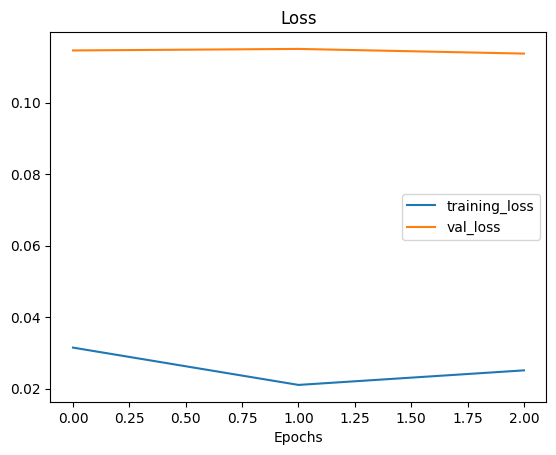

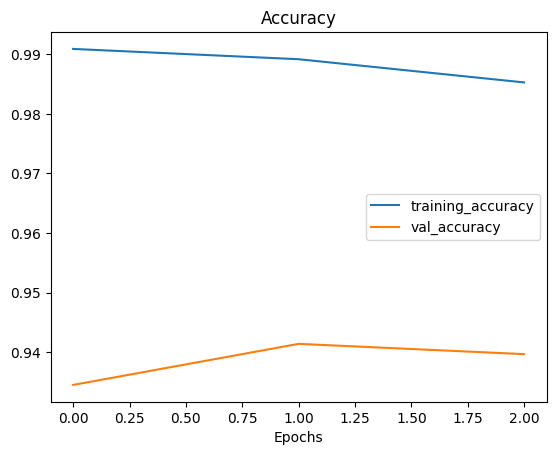

In [11]:
train_dataset = TextCodeDataset(df_train,tokenizer)
val_dataset = TextCodeDataset(df_train,tokenizer)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn,num_workers=0)
test_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn,num_workers=0)

def train_model(model,df_train,df_val, device, optimizer,tokenizer,epochs=3):
    model.to(device)
    train_losses=[]
    train_accuracies= []
    val_losses = []
    val_accuracies = []
    train_dataset = TextCodeDataset(df_train,tokenizer)
    val_dataset = TextCodeDataset(df_val,tokenizer)
    train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=collate_fn,num_workers=0)

    total_steps = len(train_loader) * epochs

    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    for epoch in range(epochs):
        model.train()
        n_correct = 0
        n_samples = 0
        total_loss = 0

        for i,batch in enumerate(train_loader):
            
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            code_input_ids = batch['code_input_ids'].to(device)
            code_attention_mask = batch['code_attention_mask'].to(device)
            

            model.zero_grad()
            outputs,loss,preds = None,None,None
            
            text_outputs = model(text_input_ids,attention_mask = text_attention_mask)
            code_outputs = model(code_input_ids,attention_mask = code_attention_mask)

            text_embeddings = text_outputs.last_hidden_state[:, 0, :]
            code_embeddings = code_outputs.last_hidden_state[:, 0, :]

            text_embeddings = F.normalize(text_embeddings, dim=-1)
            code_embeddings = F.normalize(code_embeddings, dim=-1)

            scores = torch.einsum('md,nd->mn', text_embeddings, code_embeddings) * 10
            labels = torch.arange(scores.shape[0]).to(scores.device)
            preds = torch.argmax(scores, dim=1)
            loss = nn.CrossEntropyLoss()(scores, labels)
   

            total_loss += loss.item()
            loss.backward()
            optimizer.step()
            scheduler.step()

            n_samples += len(text_input_ids)
            n_correct += (preds == labels).sum().item()

            if i % 20 == 0 :
                print(f'Epoch:{epoch} Step:{i+1}/{len(train_loader)} Loss:{loss.item()}')
            if i % 100 ==  0 :
                time.sleep(5)

        results = evaluate_model(model=model,df_test=df_val,tokenizer=tokenizer)

        avg_loss = total_loss/len(train_loader)
        accuracy = n_correct/n_samples
        
        train_losses.append(avg_loss)
        train_accuracies.append(accuracy)
        val_accuracies.append(results['accuracy'])
        val_losses.append(results['loss'])

    print("\n===== Training Summary =====")
    for epoch in range(len(train_losses)):
        print(
        f"Epoch {epoch+1:02d} | "
        f"Train Loss: {train_losses[epoch]:.4f} | "
        f"Train Acc: {train_accuracies[epoch]*100:.2f}% | "
        f"Val Loss: {val_losses[epoch]:.4f} | "
        f"Val Acc: {val_accuracies[epoch]*100:.2f}%"
        )
    print("============================\n")

    return train_losses,train_accuracies,val_losses,val_accuracies


        
def run_training(model_name,tokenizer,df_train,df_val,epochs = 3,learning_rate = 2e-5):
    gc.collect() 
    torch.cuda.empty_cache()      

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = AutoModel.from_pretrained(model_name)

    optimizer = AdamW(model.parameters(), lr=learning_rate,weight_decay =0.01)
    
    train_losses,train_accuracies,val_losses,val_accuracies= train_model(model,
                                          df_train=df_train,
                                          df_val = df_val, 
                                          device=device,
                                          optimizer=optimizer, 
                                          tokenizer=tokenizer, 
                                          epochs=epochs
                                        )
    
    plot_loss_curves(train_accuracies,train_losses,val_accuracies,val_losses)
    torch.cuda.synchronize()
    gc.collect()
    torch.cuda.empty_cache()
    print("Training finished.")
    return model


def evaluate_model(model,df_test,tokenizer):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    model.eval()

    val_dataset = TextCodeDataset(df_test,tokenizer)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, collate_fn=collate_fn,num_workers=0)

    n_correct = 0
    n_samples = 0
    total_loss = 0

    with torch.no_grad():
        for batch in val_loader:
            text_input_ids = batch['text_input_ids'].to(device)
            text_attention_mask = batch['text_attention_mask'].to(device)
            code_input_ids = batch['code_input_ids'].to(device)
            code_attention_mask = batch['code_attention_mask'].to(device)
            
            outputs,loss,preds = None,None,None
                
            text_outputs = model(text_input_ids,attention_mask = text_attention_mask)
            code_outputs = model(code_input_ids,attention_mask = code_attention_mask)

            text_embeddings = text_outputs.last_hidden_state[:, 0, :]
            code_embeddings = code_outputs.last_hidden_state[:, 0, :]

            text_embeddings = F.normalize(text_embeddings, dim=-1)
            code_embeddings = F.normalize(code_embeddings, dim=-1)

            scores = torch.einsum('md,nd->mn', text_embeddings, code_embeddings) * 10
            labels = torch.arange(scores.shape[0]).to(scores.device)
            preds = torch.argmax(scores, dim=1)
            loss = nn.CrossEntropyLoss()(scores, labels)
                
            total_loss += loss.item()

            n_samples += labels.shape[0]
            n_correct += (preds == labels).sum().item()

    avg_loss = total_loss/len(val_loader) 
    acc = n_correct/ n_samples
    return {'accuracy':acc,"loss":avg_loss}
if torch.cuda.is_available():
    torch.cuda.synchronize()
gc.collect()
torch.cuda.empty_cache()
model = run_training(model_name=model_name,tokenizer=tokenizer,df_train=df_train,df_val=df_val)